In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from estimators import *
from utils import *

Time:18.257828950881958


,S,d,n,True mean Y0,Impute mean Y0,Drop mean Y0,Oracle-IPCW mean Y0,True mean Y1,Impute mean Y1,Drop mean Y1,Oracle-IPCW mean Y1,True ATE,Impute ATE,Drop ATE,Oracle-IPCW ATE
0,0,8,200,1.847419,1.862296,1.859020,1.779510,4.776820,4.700629,4.700629,4.984611,2.929401,2.838333,2.841609,3.205101
1,1,8,800,1.889433,1.950478,1.952121,1.817401,4.060983,3.028167,3.041793,3.253660,2.171550,1.077689,1.089672,1.436260


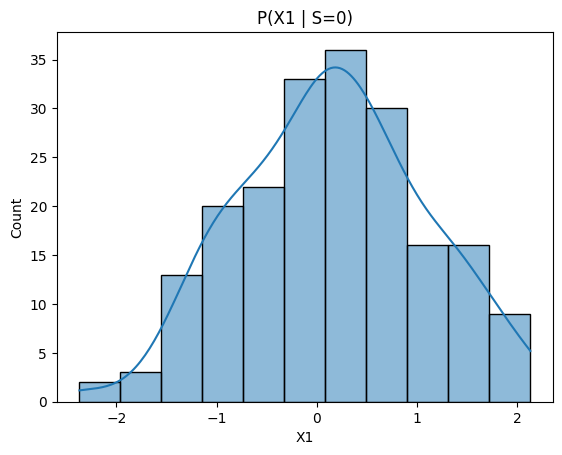

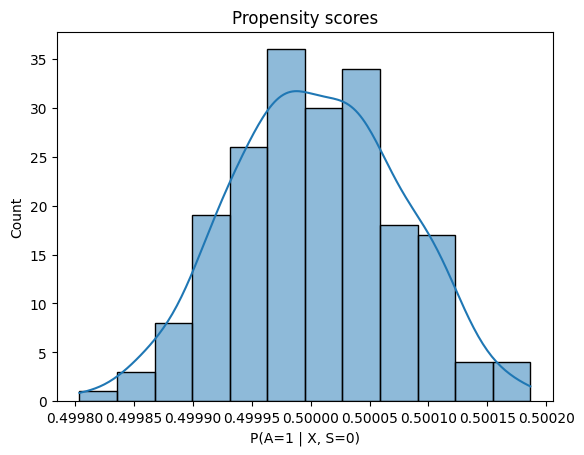

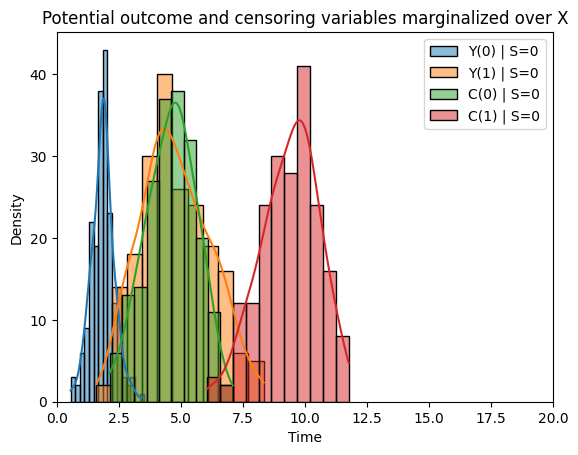

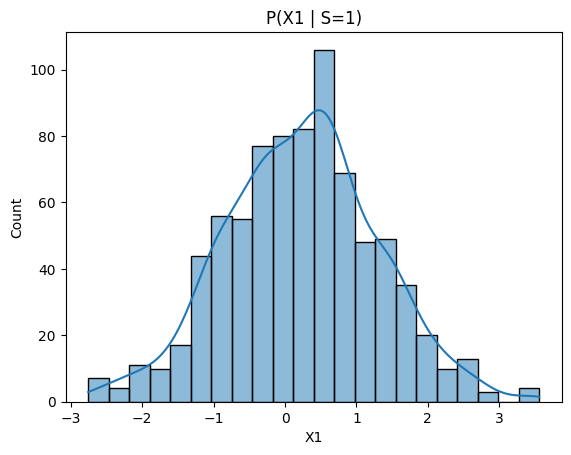

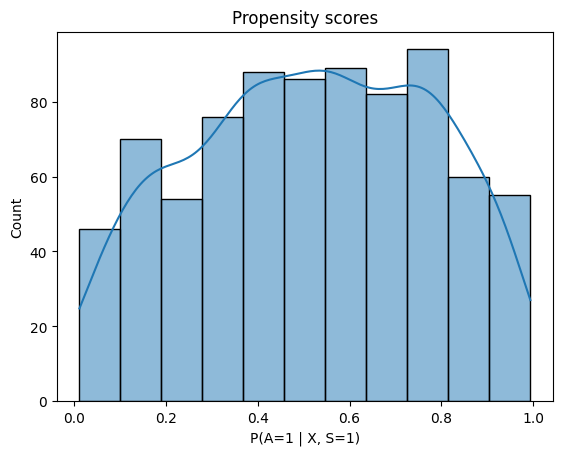

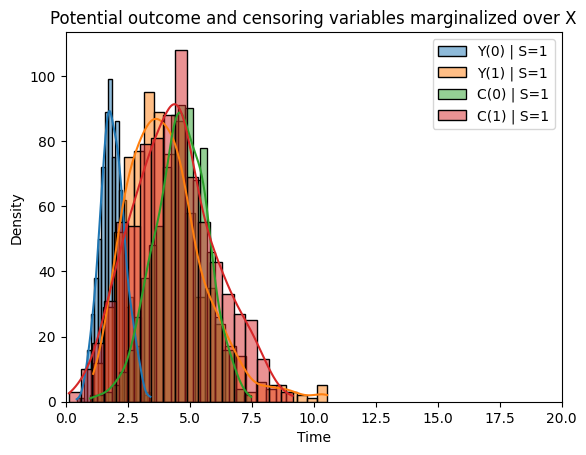

In [3]:
rct_size = 200
m = 4
CD = 8
UC = 0

jD = read_json('complete-IC/samePO.json', CD, UC, ["IPCW", "CDR"])
test_signals = jD["test_signals"]

RCTData = SyntheticDataModule(jD['save_df'], CD, rct_size, 0, jD['RCT']['px_dist'], jD['RCT']['px_args'], jD['RCT']['prop_fn'], jD['RCT']['prop_args'], jD['RCT']['tte_params'])
OSData = SyntheticDataModule(jD['save_df'], CD, rct_size * m, 1, jD['OS']['px_dist'], jD['OS']['px_args'], jD['OS']['prop_fn'], jD['OS']['prop_args'], jD['OS']['tte_params'])

df_rct_oracle, df_rct = RCTData.get_df()
df_os_oracle, df_os = OSData.get_df()

df_combined = pd.concat([df_rct, df_os], axis=0, ignore_index=True)  # merge the dataframes into one
df_comb_drop = df_combined.query('Delta == 1').reset_index(drop=True).copy()  # drop the censored observations

# Estimate the nuisance parameters for the combined dataframe

df_combined['P(S=1|X)'] = prop_score_est(df_combined.copy(), 'S', jD['cov_list'], 'logistic')

df_combined.loc[df_combined.S==0, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==0').copy(), 'A', jD['cov_list'], 'logistic')
df_combined.loc[df_combined.S==1, 'P(A=1|X,S)'] = prop_score_est(df_combined.query('S==1').copy(), 'A', jD['cov_list'], 'logistic')

cbse, ybse = est_surv(df_combined, jD['cov_list'], tte_model='coxph')
fill_barG(df_combined, jD['cov_list'], cbse)

if any("IPCW" in key for key in test_signals.keys()):
    ipcw_est(df_combined, S=0)
    ipcw_est(df_combined, S=1)

if any("IPW-Impute" in key for key in test_signals.keys()):
    ipw_est(df_combined, S=0, baseline='impute')  # censored observations are IMPUTED
    ipw_est(df_combined, S=1, baseline='impute')  # censored observations are IMPUTED

t1 = time()

if any("CDR" in key for key in test_signals.keys()):
    cdr_est(df_combined, jD['cov_list'], cbse, ybse, S=0)  
    cdr_est(df_combined, jD['cov_list'], cbse, ybse, S=1) 
    
t2 = time()
print(f"Time:{t2 - t1}")

# Estimate the nuisance parameters for the combined dataframe with censored observations dropped
    
if any("IPW-Drop" in key for key in test_signals.keys()):
    df_comb_drop['P(S=1|X)'] = prop_score_est(df_comb_drop.copy(), 'S', jD['cov_list'], 'logistic')

    df_comb_drop.loc[df_comb_drop.S==0, 'P(A=1|X,S)'] = prop_score_est(df_comb_drop.query('S==0').copy(), 'A', jD['cov_list'], 'logistic')
    df_comb_drop.loc[df_comb_drop.S==1, 'P(A=1|X,S)'] = prop_score_est(df_comb_drop.query('S==1').copy(), 'A', jD['cov_list'], 'logistic')

    ipw_est(df_comb_drop, S=0, baseline='drop')  # censored observations are DROPPED
    ipw_est(df_comb_drop, S=1, baseline='drop')  # censored observations are DROPPED

summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
summary_df

In [ ]:
df_combined['P(S=1|X)'].max()

In [5]:
df_new = df_combined
df_new_drop = df_comb_drop

In [8]:
print('CDR-S0-ATE: {:.2f}\n'.format(df_new['S0_cdr_est_CATE'].mean()))
print('CDR-S1-ATE: {:.2f}\n'.format(df_new['S1_cdr_est_CATE'].mean()))

print('IPCW-S0-Y0: {:.2f}'.format(df_new['S0_ipcw_est_Y0'].mean()))
print('IPCW-S0-Y1: {:.2f}'.format(df_new['S0_ipcw_est_Y1'].mean()))
print('IPCW-S0-ATE: {:.2f}\n'.format(df_new['S0_ipcw_est_CATE'].mean()))

print('IPCW-S1-Y0: {:.2f}'.format(df_new['S1_ipcw_est_Y0'].mean()))
print('IPCW-S1-Y1: {:.2f}'.format(df_new['S1_ipcw_est_Y1'].mean()))
print('IPCW-S1-ATE: {:.2f}\n'.format(df_new['S1_ipcw_est_CATE'].mean()))

# print('IPW-Impute-S0-Y0: {:.2f}'.format(df_new['S0_impute_ipw_est_Y0'].mean()))
# print('IPW-Impute-S0-Y1: {:.2f}'.format(df_new['S0_impute_ipw_est_Y1'].mean()))
# print('IPW-Impute-S0-ATE: {:.2f}\n'.format(df_new['S0_impute_ipw_est_CATE'].mean()))

# print('IPW-Impute-S1-Y0: {:.2f}'.format(df_new['S1_impute_ipw_est_Y0'].mean()))
# print('IPW-Impute-S1-Y1: {:.2f}'.format(df_new['S1_impute_ipw_est_Y1'].mean()))
# print('IPW-Impute-S1-ATE: {:.2f}\n'.format(df_new['S1_impute_ipw_est_CATE'].mean()))

# print('IPW-Drop-S0-Y0: {:.2f}'.format(df_new_drop['S0_drop_ipw_est_Y0'].mean()))
# print('IPW-Drop-S0-Y1: {:.2f}'.format(df_new_drop['S0_drop_ipw_est_Y1'].mean()))
# print('IPW-Drop-S0-ATE: {:.2f}\n'.format(df_new_drop['S0_drop_ipw_est_CATE'].mean()))

# print('IPW-Drop-S1-Y0: {:.2f}'.format(df_new_drop['S1_drop_ipw_est_Y0'].mean()))
# print('IPW-Drop-S1-Y1: {:.2f}'.format(df_new_drop['S1_drop_ipw_est_Y1'].mean()))
# print('IPW-Drop-S1-ATE: {:.2f}'.format(df_new_drop['S1_drop_ipw_est_CATE'].mean()))

summary_df

CDR-S0-ATE: 2.37

CDR-S1-ATE: 4890534409015304072338002610045044776321681638770909825368936214985117542435337213299889792677694148986581006726770735642051680995566332355126790172784798147492183537457249060568216523790306663474559090126616728529446071606429277472107014305209101801837648711780328451568053080384863501025280.00

IPCW-S0-Y0: 1.97
IPCW-S0-Y1: 4.39
IPCW-S0-ATE: 2.42

IPCW-S1-Y0: 1.87
IPCW-S1-Y1: 3.19
IPCW-S1-ATE: 1.33



,S,d,n,True mean Y0,Impute mean Y0,Drop mean Y0,Oracle-IPCW mean Y0,True mean Y1,Impute mean Y1,Drop mean Y1,Oracle-IPCW mean Y1,True ATE,Impute ATE,Drop ATE,Oracle-IPCW ATE
0,0,8,200,1.847419,1.862296,1.859020,1.779510,4.776820,4.700629,4.700629,4.984611,2.929401,2.838333,2.841609,3.205101
1,1,8,800,1.889433,1.950478,1.952121,1.817401,4.060983,3.028167,3.041793,3.253660,2.171550,1.077689,1.089672,1.436260


In [9]:
df_combined

,X0,X1,X2,X3,X4,X5,X6,X7,X8,S,...,"P(A=1|X,S)","G_bar(T|X,S,A)",S0_ipcw_est_CATE,S0_ipcw_est_Y1,S0_ipcw_est_Y0,S1_ipcw_est_CATE,S1_ipcw_est_Y1,S1_ipcw_est_Y0,S0_cdr_est_CATE,S1_cdr_est_CATE
0,1.0,0.081521,2.730021,-0.409749,0.752933,-1.128082,0.019359,0.434121,1.738461,0,...,0.487398,0.959106,-7.675453,-0.000000,7.675453,0.000000,0.000000,-0.000000,9.967763,0.000000e+00
1,1.0,0.334851,-0.284957,1.607963,0.228224,-0.465400,-0.663957,0.090697,3.263501,0,...,0.605600,1.000000,35.161072,35.161072,-0.000000,0.000000,0.000000,-0.000000,10.765977,0.000000e+00
2,1.0,0.042763,0.597444,-1.372470,0.369816,1.045726,0.280804,-1.688190,-0.562056,0,...,0.640571,1.000000,18.105575,18.105575,-0.000000,0.000000,0.000000,-0.000000,7.987707,0.000000e+00
3,1.0,-1.142898,-0.836495,-0.634460,-0.302610,0.287895,1.957233,2.583147,-0.601466,0,...,0.367467,0.977438,-7.725087,-0.000000,7.725087,0.000000,0.000000,-0.000000,6.857404,0.000000e+00
4,1.0,-1.145115,-0.166104,-0.692511,0.424044,-1.094747,-0.414256,0.484847,0.262982,0,...,0.418560,1.000000,30.320772,30.320772,-0.000000,0.000000,0.000000,-0.000000,8.940858,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.0,1.106569,0.261020,0.056568,0.876350,-1.352182,1.528618,-0.611068,-1.308560,1,...,0.834112,0.933842,0.000000,0.000000,-0.000000,2.947462,2.947462,-0.000000,0.000000,4.499110e+17
996,1.0,0.777198,-0.367887,-0.246955,-0.219549,0.926334,1.376148,0.786478,0.781968,1,...,0.164263,0.991512,0.000000,0.000000,-0.000000,-3.355457,-0.000000,3.355457,0.000000,1.528233e+00
997,1.0,-1.688157,0.317082,1.201277,0.363260,0.006295,-0.029904,-1.835744,-0.146195,1,...,0.721353,0.993175,0.000000,0.000000,-0.000000,-6.194149,-0.000000,6.194149,0.000000,-1.183150e+00
998,1.0,1.004869,-1.047354,0.522196,0.809115,0.118204,-0.504013,-0.111481,0.729037,1,...,0.436641,0.989626,0.000000,0.000000,-0.000000,-4.036049,-0.000000,4.036049,0.000000,1.546362e+00


In [ ]:
p_thr = 0.05

df_new = df_combined[(p_thr < df_combined['P(S=1|X)']) & (df_combined['P(S=1|X)'] < 1 - p_thr) &\
            (p_thr < df_combined['P(A=1|X,S)']) & (df_combined['P(A=1|X,S)'] < 1 - p_thr)].copy().reset_index(drop=True)

df_new_drop = df_comb_drop[(p_thr < df_comb_drop['P(S=1|X)']) & (df_comb_drop['P(S=1|X)'] < 1 - p_thr) &\
            (p_thr < df_comb_drop['P(A=1|X,S)']) & (df_comb_drop['P(A=1|X,S)'] < 1 - p_thr)].copy().reset_index(drop=True)

In [ ]:
len(df_new)

In [ ]:
df_combined.sort_values(by='P(S=1|X)')

In [ ]:
s, a = 0, 1
ty, sty = ybse[f't_S{s}_A{a}'], ybse[f'St_S{s}_A{a}']
tc, stc = cbse[f't_S{s}_A{a}'], cbse[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

t1 = time()
func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
result, error = quad(func, 0, t_arr.max() + 10, limit=5)

print(f"Time: {time()-t1:.2f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max() + 10, 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()